#### Q1: How is the concept of prediction in machine learning broad enough to include tasks such as language translation and self-driving cars?
* Prediction in machine learning is broadly defined as mapping from defined inputs to well-defined outputs. This allows tasks like language translation (predicting text in one language from another) and self-driving cars (predicting actions based on sensor data) to be framed as prediction problems.

#### Q2: Explain how machine learning can be utilized to identify profitable customers in the context of customer acquisition.
* Machine learning can predict which customers will be profitable by analyzing patterns in data such as marketing costs and revenue generation. This helps in focusing efforts on potentially profitable customers, improving efficiency and profitability.

#### Q3: What is the purpose of cross-validation in machine learning, and how does it help in model selection and evaluation?
* Cross-validation is used to assess the generalizability of a machine learning model to new data. It involves dividing the data into subsets, using some for training and others for validation. This process helps in selecting models that perform well on unseen data, ensuring reliability.

#### Q4: Differentiate between a prediction and a policy in the context of machine learning applications in business.
* A prediction is an estimate of a specific outcome, like a customer's profitability. A policy is a decision rule derived from predictions, such as engaging only with customers predicted to be profitable. Policies use predictions to make strategic business decisions.

#### Q5: How can machine learning predictions inform more nuanced business decisions beyond binary choices, such as how much to invest in marketing for individual customers?
* Machine learning can provide detailed predictions that help in making nuanced decisions, like determining the exact amount of marketing investment for individual customers based on predicted returns. This allows businesses to optimize resource allocation and maximize returns on investment.


In [10]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
palette = sns.color_palette("colorblind", 10)

import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("/content/sample_data/customer_features.csv")
df.head()

,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


In [16]:
train, test = train_test_split(df, test_size=0.3, random_state=16)
train.shape, test.shape

((7000, 5), (3000, 5))

In [17]:
train['net_value'].mean()

-27.351142857142857

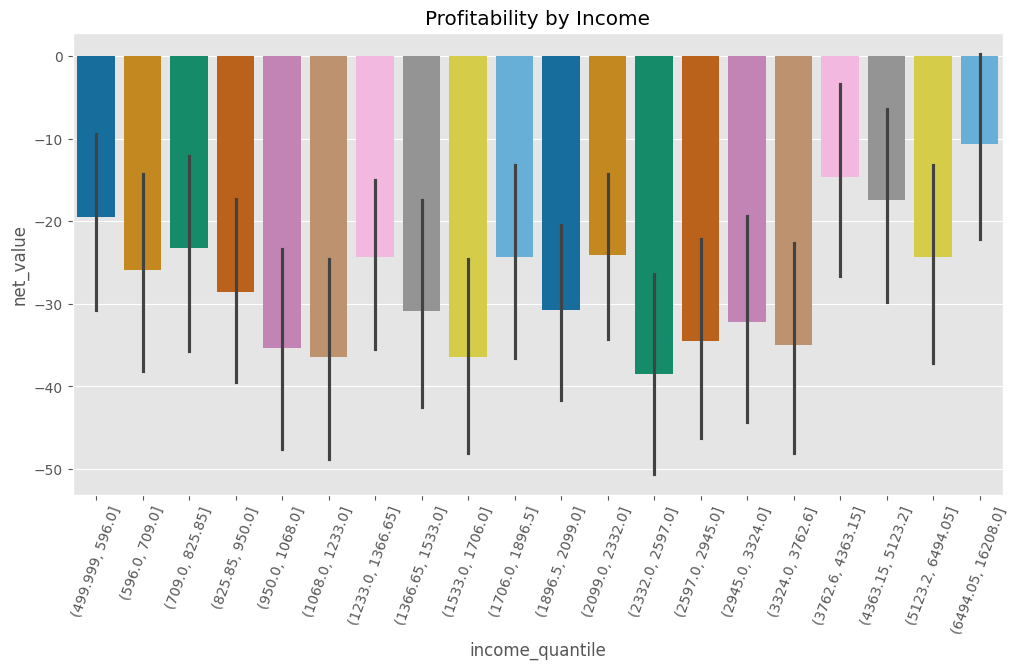

In [18]:
plt.figure(figsize=(12,6))
np.random.seed(123)

sns.barplot(data=train.assign(income_quantile = pd.qcut(train['income'], q=20)),
            x='income_quantile', y='net_value', palette = palette)
plt.title('Profitability by Income')
plt.xticks(rotation=70)
plt.show()

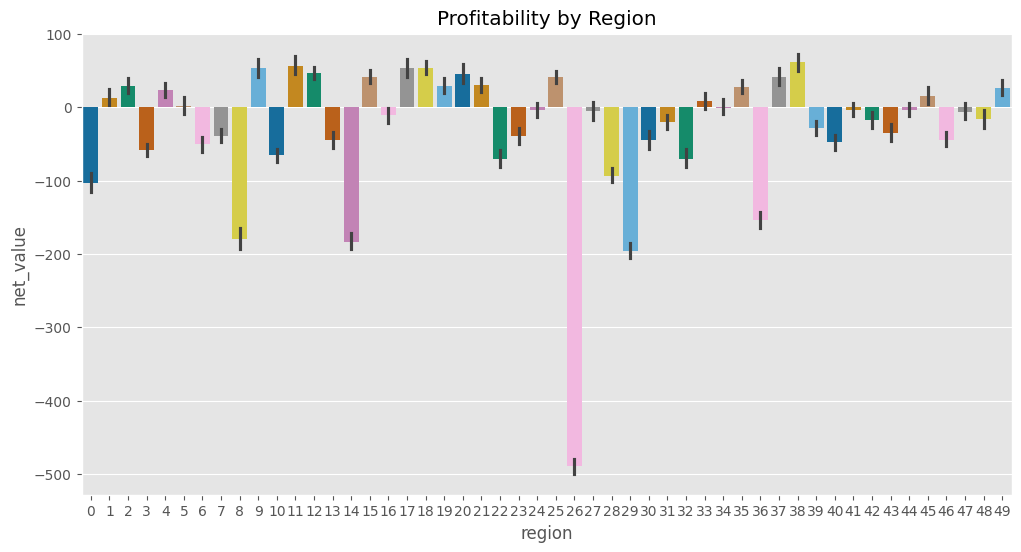

In [19]:
plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value", palette = palette)
plt.title("Profitability by Region");

In [20]:
from typing_extensions import NewType
regions_to_net = train.groupby('region')['net_value'].agg(['mean','count','std'])

regions_to_net = regions_to_net.assign(
    lower_bound = regions_to_net['mean'] - 1.96*regions_to_net['std'] / (regions_to_net['count']**0.5)
)

regions_to_net_lower_bound = regions_to_net['lower_bound'].to_dict()
regions_to_net = regions_to_net['mean'].to_dict()

regions_to_invest = {region : net
                     for region, net in regions_to_net_lower_bound.items()
                     if net > 0}

regions_to_invest

{1: 2.669578379061676,
 2: 18.40315491385723,
 4: 13.245521696714956,
 9: 41.47398929769058,
 11: 44.293006200296595,
 12: 38.163796139316794,
 15: 32.81952827040055,
 17: 40.868699077663294,
 18: 44.08960035855211,
 19: 18.969450097737173,
 20: 31.794450127207384,
 21: 21.50272865044252,
 25: 33.261546648570054,
 35: 18.634182139430767,
 37: 30.230070353713373,
 38: 49.43156122722313,
 45: 3.0121123880526124,
 49: 16.388534096077024}

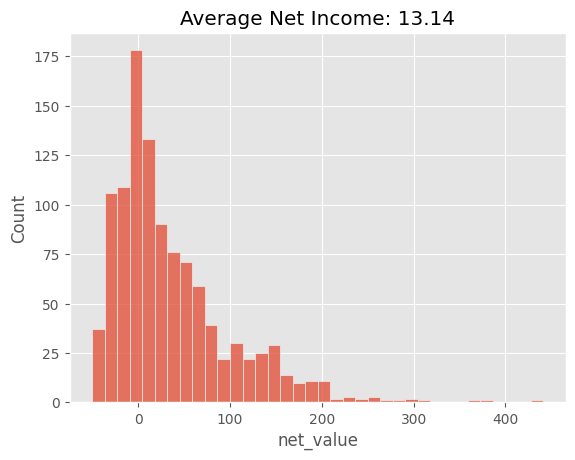

In [21]:
region_policy = (test[test['region'].isin(regions_to_invest.keys())])

sns.histplot(data=region_policy, x = 'net_value')
plt.title('Average Net Income: %.2f' % (region_policy['net_value'].sum() / test.shape[0]))
plt.show()

In [22]:
def encode(data):
  return data.replace({'region':regions_to_net})

In [24]:
model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'squared_error'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(123)

model = ensemble.GradientBoostingRegressor(**model_params)

encoded_train = train[features].pipe(encode)
model.fit(encoded_train, train[target])

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=10,
                          n_estimators=400)

In [27]:
train_pred = (encoded_train
              .assign(predictions=model.predict(encoded_train[features])))

print("Train R2: ", r2_score(y_true=train[target], y_pred=train_pred["predictions"]))
print("Test R2: ", r2_score(y_true=test[target], y_pred=model.predict(test[features].pipe(encode))))

Train R2:  0.708290875454147
Test R2:  0.6891901271429393


In [28]:
model_policy = test.assign(prediction=model.predict(test[features].pipe(encode)))
model_policy.head()

,customer_id,region,income,age,net_value,prediction
7151,7151,27,583,28,-26,-21.072448
470,470,35,1311,31,-32,5.648297
4012,4012,29,607,24,-218,-183.315085
8575,8575,29,1913,32,-225,-209.667430
1455,1455,37,1629,30,28,24.357247


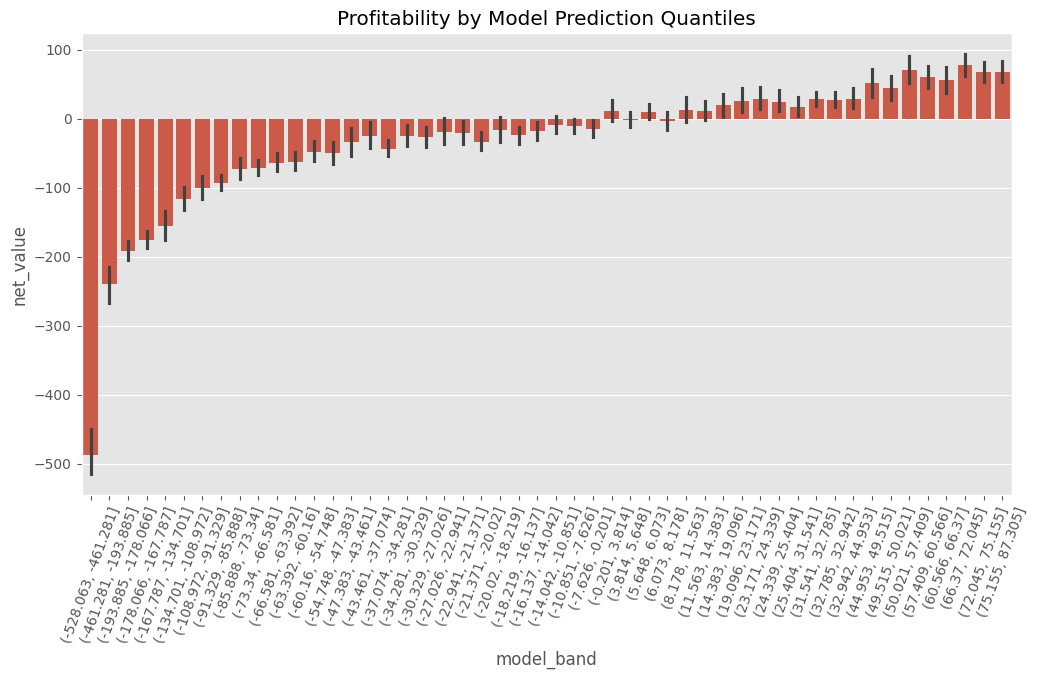

In [29]:
plt.figure(figsize=(12,6))

n_bands = 50
bands = [f"band_{b}" for b in range(1,n_bands+1)]

np.random.seed(123)
model_plot = sns.barplot(data=model_policy
                         .assign(model_band = pd.qcut(model_policy["prediction"], q=n_bands)),
                         x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70);

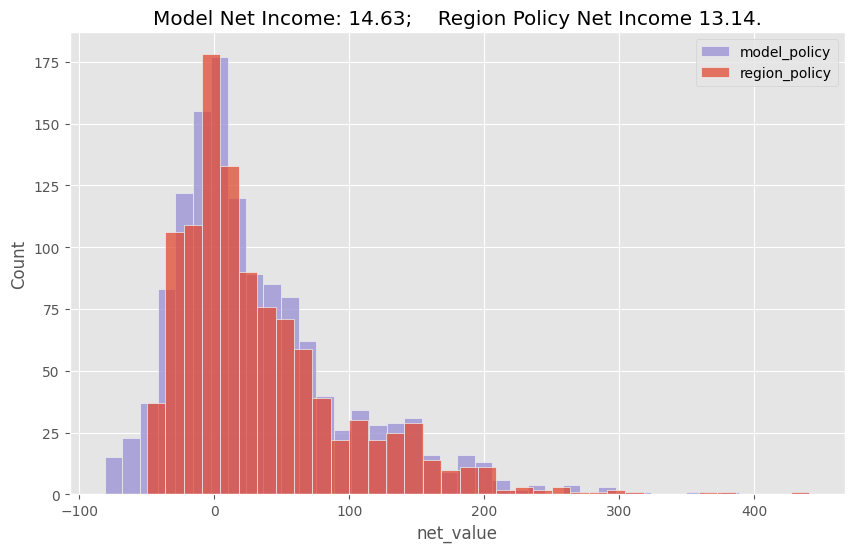

In [30]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")

region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f;    Region Policy Net Income %.2f." %
          (model_plot_df["net_value"].sum() / test.shape[0],
           region_plot_df["net_value"].sum() / test.shape[0]))
plt.legend();

In [31]:
def model_binner(prediction_column, bins):
    bands = pd.qcut(prediction_column, q=bins, retbins=True)[1]

    def binner_function(prediction_column):
        return np.digitize(prediction_column, bands)

    return binner_function

In [32]:
binner_fn = model_binner(train_pred["predictions"], 20)

model_band = model_policy.assign(bands = binner_fn(model_policy["prediction"]))
model_band.head()

,customer_id,region,income,age,net_value,prediction,bands
7151,7151,27,583,28,-26,-21.072448,9
470,470,35,1311,31,-32,5.648297,12
4012,4012,29,607,24,-218,-183.315085,1
8575,8575,29,1913,32,-225,-209.667430,1
1455,1455,37,1629,30,28,24.357247,15


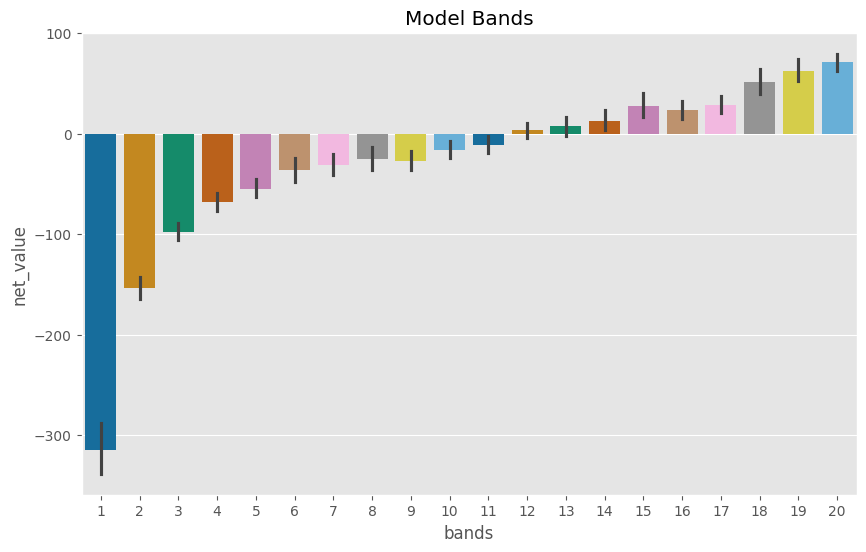

In [34]:
plt.figure(figsize=(10,6))

sns.barplot(data=model_band, x="bands", y="net_value", palette = palette)
plt.title("Model Bands");

In [38]:
model_band['mkt_investments'] = model_band['prediction'] * 0.3
model_band[model_band['mkt_investments'] > 0]

,customer_id,region,income,age,net_value,prediction,bands,mkt_investments
470,470,35,1311,31,-32,5.648297,12,1.694489
1455,1455,37,1629,30,28,24.357247,15,7.307174
5965,5965,44,2281,26,-43,10.260696,13,3.078209
5823,5823,44,4093,23,4,21.757097,15,6.527129
9640,9640,5,3156,22,-10,22.023075,15,6.606922
...,...,...,...,...,...,...,...,...
7270,7270,16,1550,25,-71,8.177696,13,2.453309
5819,5819,11,1963,31,61,32.774180,17,9.832254
6978,6978,4,8338,31,10,10.975564,13,3.292669
8092,8092,21,1527,24,6,49.615175,18,14.884552
